<a href="https://colab.research.google.com/github/ashutoshg-2005/Sentiment-Analysis/blob/master/IEEE_TASK1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow
!pip install numpy pandas scikit-learn


In [2]:
from google.colab import files
uploaded = files.upload()


Saving IMDB Dataset.csv to IMDB Dataset.csv


In [3]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
df = pd.read_csv('IMDB Dataset.csv')
print(df.head())
df.isnull().sum()
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['review'])
train_sequences = tokenizer.texts_to_sequences(train_data['review'])
test_sequences = tokenizer.texts_to_sequences(test_data['review'])
max_length = 200

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

train_labels = np.array([1 if label == 'positive' else 0 for label in train_data['sentiment']])
test_labels = np.array([1 if label == 'positive' else 0 for label in test_data['sentiment']])


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [4]:
import os
from zipfile import ZipFile
import urllib.request

# Download GloVe embeddings (6B tokens, 100-dimensional vectors)
!wget http://nlp.stanford.edu/data/glove.6B.zip
# Unzipping the file
with ZipFile('glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Load GloVe embeddings into a dictionary
embedding_index = {}
with open("glove.6B.100d.txt", "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefficients = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefficients

embedding_dim = 100
embedding_matrix = np.zeros((10000, embedding_dim))

for word, index in tokenizer.word_index.items():
    if index < 10000:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector


--2025-04-28 16:01:34--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-28 16:01:34--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-28 16:01:35--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False))
model.add(LSTM(128, return_sequences=False))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

In [6]:

history = model.fit(train_padded, train_labels, epochs=10, batch_size=128, validation_data=(test_padded, test_labels))


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5117 - loss: 0.6937 - val_accuracy: 0.6374 - val_loss: 0.6563
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5452 - loss: 0.6839 - val_accuracy: 0.6313 - val_loss: 0.6538
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5391 - loss: 0.6890 - val_accuracy: 0.5283 - val_loss: 0.6913
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5241 - loss: 0.6898 - val_accuracy: 0.5365 - val_loss: 0.6867
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.5764 - loss: 0.6661 - val_accuracy: 0.7785 - val_loss: 0.4719
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7915 - loss: 0.4661 - val_accuracy: 0.8181 - val_loss: 0.4125
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8222 - loss: 0.4121 - val_accuracy: 0.8127 - val_loss: 0.4279
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8300 - loss: 0.3937 - val_a

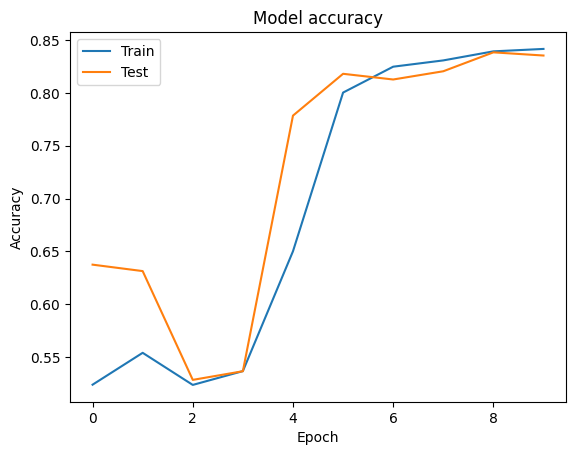

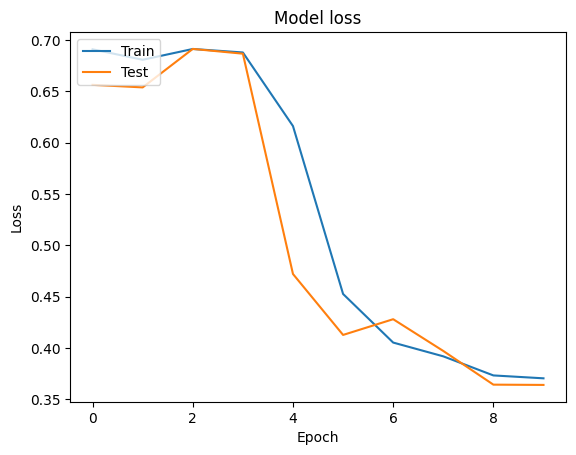

In [7]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

predictions = model.predict(test_padded)
predictions = [1 if pred > 0.5 else 0 for pred in predictions]

accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Accuracy: 0.8354
Precision: 0.8223446703401102
Recall: 0.8589005755110141
F1 Score: 0.8402251989904873


In [9]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split



# Function to analyze a new review
def analyze_review(review, tokenizer, model, max_length):
    """Analyzes a single review using the trained model.

    Args:
        review (str): The review text to analyze.
        tokenizer (Tokenizer): The tokenizer used to preprocess the training data.
        model (keras.Model): The trained sentiment analysis model.
        max_length (int): The maximum sequence length for padding.

    Returns:
        str: The predicted sentiment ('positive' or 'negative').
    """
    sequence = tokenizer.texts_to_sequences([review])  # Tokenize the review
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')  # Pad the sequence
    prediction = model.predict(padded_sequence)[0][0]  # Get the prediction
    sentiment = 'positive' if prediction > 0.5 else 'negative'  # Determine sentiment
    return sentiment

# Get user input for the review
user_review = input("Enter your review: ")

# Analyze the user's review
predicted_sentiment = analyze_review(user_review, tokenizer, model, max_length)

# Print the predicted sentiment
print(f"Predicted sentiment: {predicted_sentiment}")

Enter your review: had plot holes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted sentiment: negative
